In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [3]:
!gdown --id 1AcuwzaBwZchcRTXYodqvcM8e3CU86SWq

Downloading...
From: https://drive.google.com/uc?id=1AcuwzaBwZchcRTXYodqvcM8e3CU86SWq
To: /content/Sunspots.csv
100% 70.8k/70.8k [00:00<00:00, 28.1MB/s]


In [32]:
import csv
time_step = []
sunspots = []

with open('Sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

print(sunspots)
series = np.array(sunspots)
time = np.array(time_step)
print('original data =', series)
print('original time =', time)

min = np.min(series)
max = np.max(series)
series -= min
series /= max
print('after min max=', series)

[96.7, 104.3, 116.7, 92.8, 141.7, 139.2, 158.0, 110.5, 126.5, 125.8, 264.3, 142.0, 122.2, 126.5, 148.7, 147.2, 150.0, 166.7, 142.3, 171.7, 152.0, 109.5, 105.5, 125.7, 116.7, 72.5, 75.5, 94.0, 101.2, 84.5, 110.5, 99.7, 39.2, 38.7, 47.5, 73.3, 58.3, 83.3, 118.3, 98.8, 99.5, 66.0, 130.7, 48.8, 45.2, 77.7, 62.7, 66.7, 73.3, 53.3, 76.2, 63.3, 60.0, 52.8, 36.7, 65.0, 46.7, 41.7, 33.3, 11.2, 0.0, 5.0, 2.8, 22.8, 34.5, 44.5, 31.3, 20.5, 13.7, 40.2, 22.0, 7.0, 17.0, 18.7, 11.3, 10.8, 0.0, 0.0, 14.3, 5.3, 29.7, 39.5, 11.3, 33.3, 20.8, 11.8, 9.0, 15.7, 20.8, 21.5, 6.0, 10.7, 19.7, 23.8, 28.3, 15.7, 23.5, 35.3, 43.7, 50.0, 63.5, 21.3, 41.7, 85.5, 66.2, 54.2, 107.8, 55.8, 62.7, 86.7, 81.7, 120.5, 77.3, 75.0, 73.3, 64.5, 104.2, 62.8, 71.7, 71.7, 80.5, 73.3, 78.0, 78.3, 81.7, 83.3, 85.0, 118.8, 128.7, 99.5, 77.2, 95.0, 112.2, 99.2, 124.5, 97.2, 120.0, 80.5, 110.0, 126.0, 102.2, 84.3, 99.5, 101.7, 116.7, 151.7, 134.5, 119.5, 178.7, 165.5, 156.8, 151.8, 167.8, 147.8, 149.5, 76.7, 73.0, 121.3, 76.2, 100

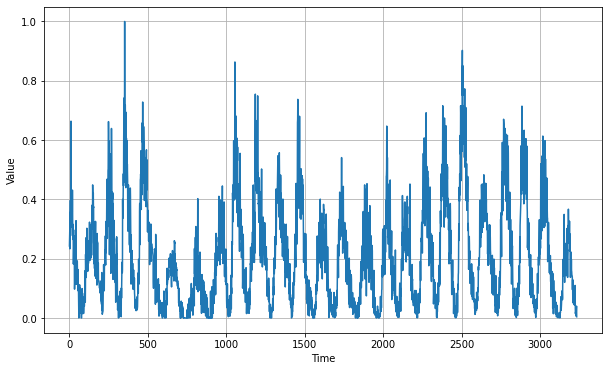

In [5]:
plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [54]:
split_time = 3000
time_train, x_train = time[:split_time], series[:split_time]
time_valid, x_valid = time[split_time:], series[split_time:]
########################     window   ########################
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [7]:
###################   build model   ######################
# tf.keras.backend.clear_session()
# tf.random.set_seed(51)
# np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer=shuffle_buffer_size)

In [8]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=5, strides=1, padding='causal', activation='relu', input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(16, activation="relu"),
  tf.keras.layers.Dense(1),
 # tf.keras.layers.Lambda(lambda x: x * 400)
])

In [9]:
model.compile(loss=tf.keras.losses.Huber(), optimizer='adam', metrics=["mae"])
history = model.fit(train_set, epochs=50, verbose=1)

Epoch 1/50
93/93 [==============================] - 18s 34ms/step - loss: 0.0065 - mae: 0.0801
Epoch 2/50
93/93 [==============================] - 3s 30ms/step - loss: 0.0030 - mae: 0.0556
Epoch 3/50
93/93 [==============================] - 3s 30ms/step - loss: 0.0025 - mae: 0.0506
Epoch 4/50
93/93 [==============================] - 3s 30ms/step - loss: 0.0022 - mae: 0.0477
Epoch 5/50
93/93 [==============================] - 3s 30ms/step - loss: 0.0020 - mae: 0.0461
Epoch 6/50
93/93 [==============================] - 3s 30ms/step - loss: 0.0020 - mae: 0.0455
Epoch 7/50
93/93 [==============================] - 3s 30ms/step - loss: 0.0020 - mae: 0.0453
Epoch 8/50
93/93 [==============================] - 3s 30ms/step - loss: 0.0020 - mae: 0.0452
Epoch 9/50
93/93 [==============================] - 3s 30ms/step - loss: 0.0020 - mae: 0.0451
Epoch 10/50
93/93 [==============================] - 3s 30ms/step - loss: 0.0020 - mae: 0.0453
Epoch 11/50
93/93 [==============================] - 3s 30

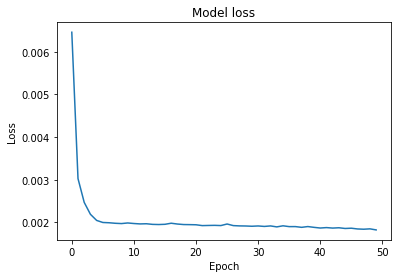

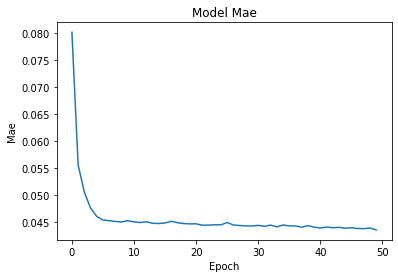

In [10]:
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

# Plotting mae values
plt.plot(history.history['mae'])
plt.title('Model Mae')
plt.ylabel('Mae')
plt.xlabel('Epoch')
plt.show()

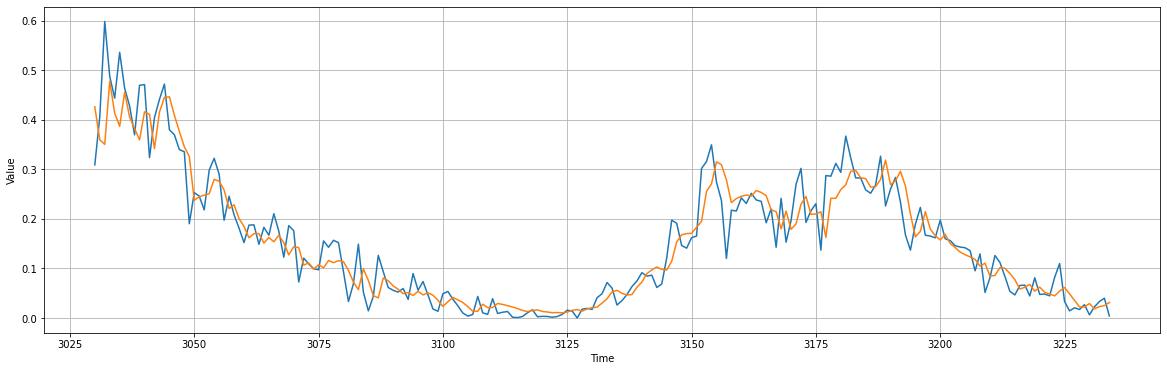

x valid= (235,)
time valid= (235,)
forecast (235,)


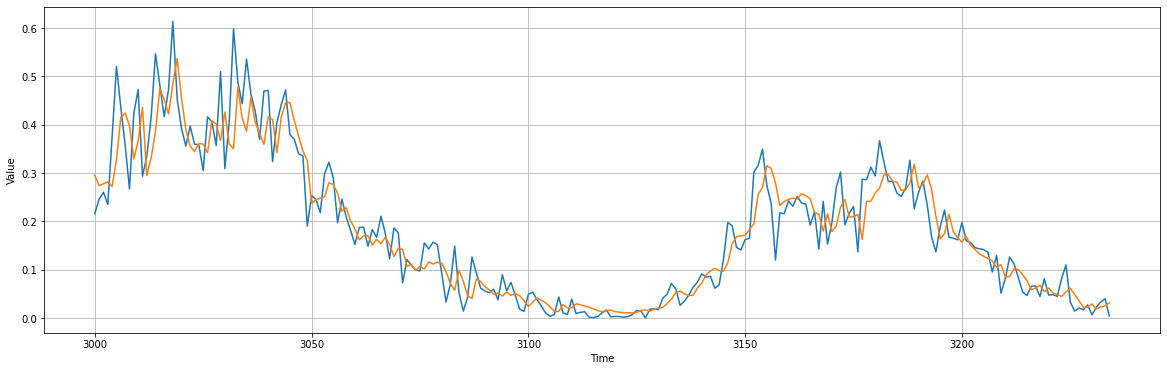

mae= 0.03631364


In [56]:
##     predict whole axis 
def test_data_pipeline(series):
    series = tf.expand_dims(series, axis=-1)
    data = tf.data.Dataset.from_tensor_slices(series)
    data = data.window(window_size, shift=1, drop_remainder=True)
    data = data.flat_map(lambda w: w.batch(window_size))
    data = data.batch(batch_size).prefetch(1)
    data = model.predict(data)
    return data

forecast2= test_data_pipeline(series)
#  forecast = model.predict(test)
# print('forcast01=', forecast.shape)   # forcast01= (3206, 30, 1)
forecast = forecast2[:, -1, 0]
forecast_valid = forecast2[split_time - window_size:-1, -1, 0]
# print('forcast01=', forecast.shape)  # forcast01= (3206,)
# print('series=', series.shape)       # series= (3235,)

time_test = time[window_size:]

series_ori = series[window_size:]
forecast = np.reshape(forecast, (-1))
forecast = forecast[:-1]
# print('forcast02=', forecast.shape)       # forcast02= (3205,)
# print('series_ori =', series_ori.shape)   #  series_ori = (3205,)

plt.figure(figsize=(20, 6))
plot_series(time_test[3000:], series_ori[3000:])
plot_series(time_test[3000:], forecast[3000:])
plt.show()

print('x valid=', x_valid.shape)
print('time valid=', time_valid.shape)
print('forecast', forecast_valid.shape)

plt.figure(figsize=(20, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast_valid)
plt.show()

result = tf.keras.metrics.mean_absolute_error(x_valid, forecast_valid).numpy()
print('mae=', result)


mae= 0.03631364
time valid= (235,)
x valid= (235,)


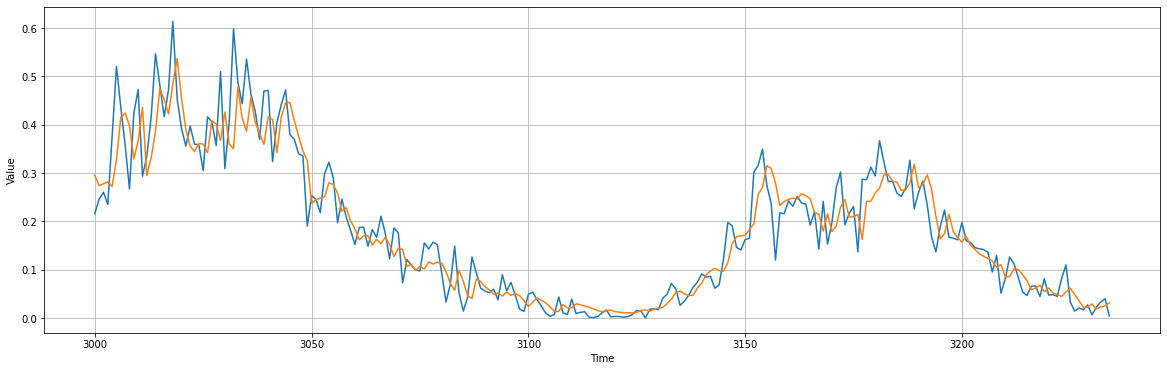

In [65]:
##  Larence book 
def model_forecast(model, series, window_size):
   ds = tf.data.Dataset.from_tensor_slices(series)
   ds = ds.window(window_size, shift=1, drop_remainder=True)
   ds = ds.flat_map(lambda w: w.batch(window_size))
   ds = ds.batch(32).prefetch(1)
   forecast = model.predict(ds)
   return forecast

# window_size = 32     # YOUR CODE HERE
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
##  print('forecast=', rnn_forecast.shape)           ##  forecast= (3206, 30, 1)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
## print('splitted forecast =', rnn_forecast.shape)   ## splitted forecast = (235,)

result = tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()
print('mae=', result)

time_valid = np.squeeze(time_valid[:rnn_forecast.shape[0]])

print('time valid=', time_valid.shape)
print('x valid=', x_valid.shape)

plt.figure(figsize=(20, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)
plt.show()
# print(rnn_forecast)

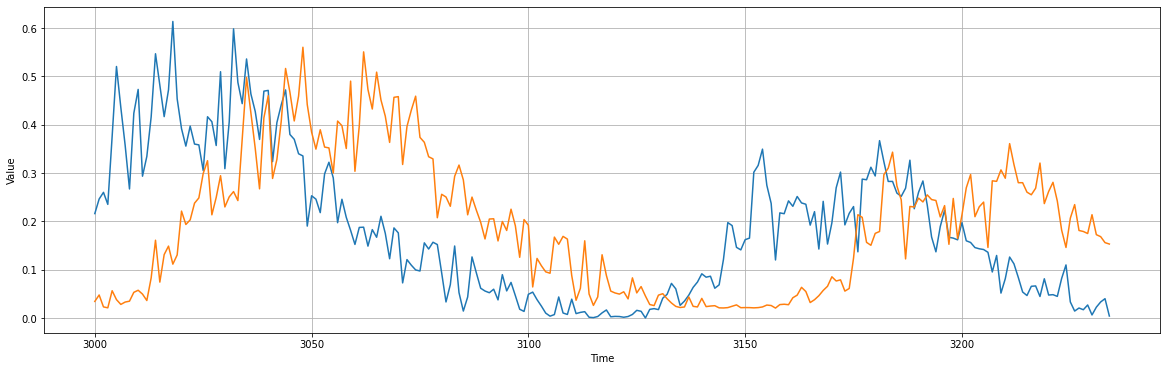

[0.15687834 0.14871277 0.16470042 0.16605285 0.14431655 0.15446985
 0.16109529 0.15776058 0.15654817 0.1458837  0.14387505 0.14774442
 0.15567157 0.13403133 0.12081674 0.13702442 0.12301555 0.12104011
 0.12671147 0.12312308 0.12972271 0.12368124 0.1255519  0.13467279
 0.13867708 0.16268401 0.17844604 0.12780103 0.13905747 0.16017768
 0.13219996 0.13952683 0.14418447 0.13659571 0.20857413 0.3166656
 0.25180572 0.19531867 0.14672287 0.24266139 0.28174207 0.15713045
 0.1801808  0.23712824 0.33435917 0.28822646 0.23750077 0.28111526
 0.37706015 0.26565558 0.21967348 0.19412628 0.22336851 0.19702525
 0.19583027 0.1632198  0.23731694 0.22979568 0.19497779 0.309459
 0.16526383 0.22943282 0.36766124 0.29320264 0.25788504 0.32710934
 0.2740498  0.24546643 0.20378593 0.27881947 0.28007132 0.17360267
 0.22853325 0.25591424 0.28090647 0.21135315 0.20396894 0.18368039
 0.1808158  0.12646566 0.14175992 0.13944812 0.13260911 0.1595283
 0.17285906 0.15560575 0.12780103 0.13936947 0.13027103 0.12449617

In [70]:
def model_forecast5(model, series, window_size):
    # series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(window_size).prefetch(1)
    forecast = model.predict(ds)
    return forecast
forecast5 = model_forecast5(model, series[split_time - window_size:-1], window_size)[:,0]

plt.figure(figsize=(20, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast5)
plt.show()

mae = tf.keras.metrics.mean_absolute_error(x_valid, forecast5).numpy()
print(mae)

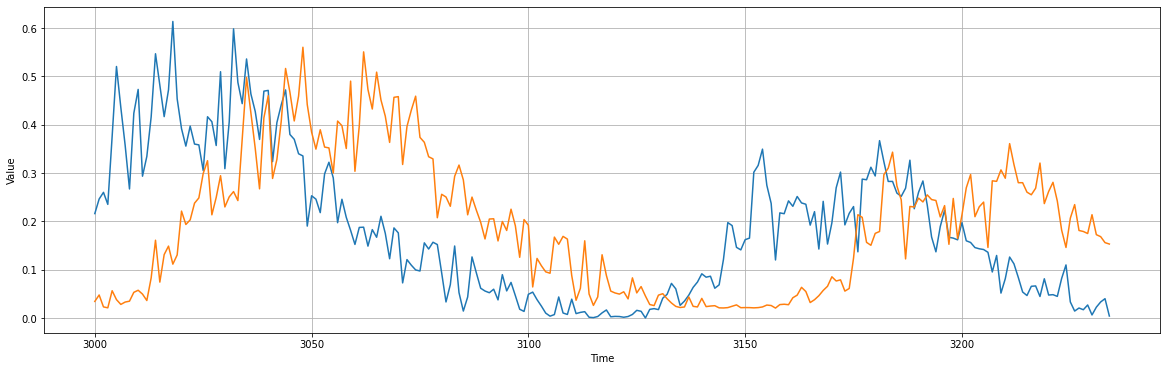

In [71]:
##   predict whole time set 
forecast3=[]
for time in range(len(series) - window_size):
  forecast3.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast3 = forecast3[split_time-window_size:]
forecast3 = np.array(forecast3)[:, 0, 0]

plt.figure(figsize=(20, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast3)
plt.show()

In [ ]:
print(forecast3.shape)
print(forecast3)